In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter

# Step 1: Generate synthetic dataset
np.random.seed(42)
num_customers = 10000

In [95]:
# Generate data 
customer_number = range(1, num_customers + 1)
register_time = pd.to_datetime('2023-01-01') + pd.to_timedelta(np.random.randint(0, 365, num_customers), unit='d')
platform = np.random.choice(['Web', 'Mobile', 'Referral'], size=num_customers, p=[0.4, 0.4, 0.2])
last_login = register_time + pd.to_timedelta(np.random.randint(1, 500, num_customers), unit='d')  # Increased variability

total_purchase = (np.random.exponential(scale=30, size=num_customers) + np.random.normal(0, 10, num_customers)).clip(0).astype(int)  # Added noise
redeemed_amount = np.random.choice([0, 10, 20, 50], size=num_customers, p=[0.6, 0.2, 0.1, 0.1])  # Adjusted probabilities for more variation

# Introduce additional random noise for churn-related variables
temp_noise = np.random.normal(0, 5, num_customers).astype(int)
total_purchase += temp_noise
redeemed_amount += np.random.choice([0, 5], size=num_customers, p=[0.9, 0.1])



In [96]:
# Construct dataset
data = pd.DataFrame({
    'customer_number': customer_number,
    'customer_register_time': register_time,
    'platform': platform,
    'last_login': last_login,
    'total_purchase': total_purchase,
    'redeemed_amount': redeemed_amount
})

In [81]:


# Save raw dataset for reference
data.to_csv('raw_customer_data.csv', index=False)

In [97]:
# Step 2: Data Cleaning Based on New Rules
# Rule 1: Churned Customers: Haven't logged in for 2 months (data['lost'])
# Rule 2: Censored Customers: If logged in the past 2 months and purchases < 50
# Rule 3: Success: Active customers with high engagement (purchases > 1000 or redemption activity)

cutoff_date = pd.to_datetime('2024-01-01') - pd.Timedelta(days=60)
data['lost'] = data['last_login'] < cutoff_date

data['churned'] = data['lost']
data['censored'] = (~data['lost']) & (data['total_purchase'] < 50)
data['success'] = (data['total_purchase'] > 1000) | (data['redeemed_amount'] > 0)

# Calculate event time as the difference between last login and register time
data['event_time'] = (data['last_login'] - data['customer_register_time']).dt.days

# Filter out rows with invalid or negative event times
data = data[data['event_time'] > 0]

# Add event observed flag (1 for observed, 0 for censored)
data['event_observed'] = ~data['censored']

In [98]:

# Save cleaned dataset
data.to_csv('cleaned_customer_data.csv', index=False)


In [99]:

# Step 3: Kaplan-Meier Survival Analysis
kmf = KaplanMeierFitter()

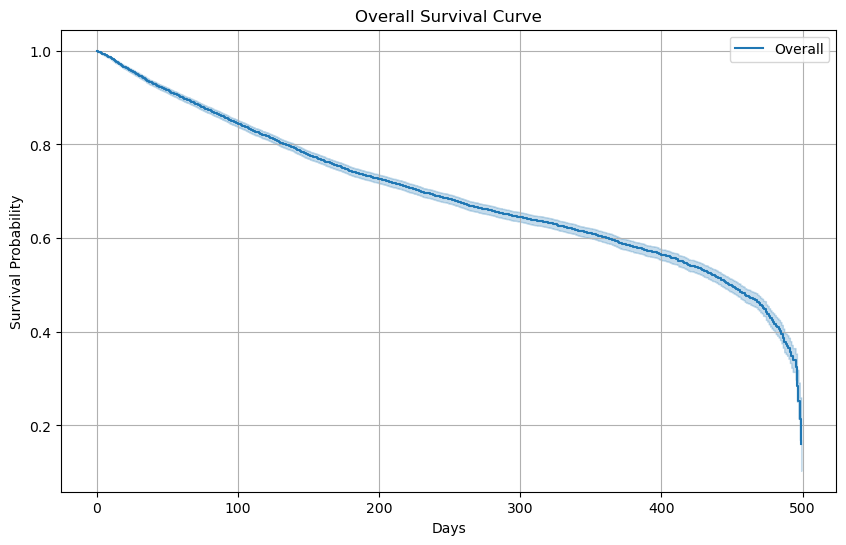

In [100]:
plt.figure(figsize=(10, 6))

# Overall survival curve
kmf.fit(durations=data['event_time'], event_observed=data['event_observed'], label='Overall')
kmf.plot_survival_function(ci_show=True)
plt.title('Overall Survival Curve')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.grid(True)

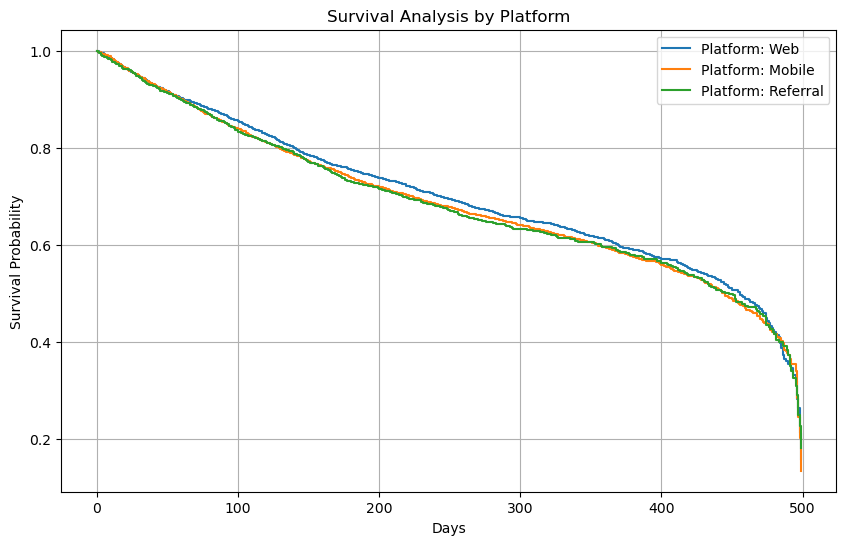

In [101]:
# Platform-wise survival curves
plt.figure(figsize=(10, 6))
for platform_name in data['platform'].unique():
    platform_data = data[data['platform'] == platform_name]
    kmf.fit(
        durations=platform_data['event_time'],
        event_observed=platform_data['event_observed'],
        label=f'Platform: {platform_name}'
    )
    kmf.plot_survival_function(ci_show=False)

plt.title('Survival Analysis by Platform')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.legend()
plt.grid(True)
plt.show()

In [102]:

# Step 4: Cox Proportional Hazards Model
cph = CoxPHFitter()
data['platform_encoded'] = data['platform'].astype('category').cat.codes

# Create redeemed_binary to ensure existence
data['redeemed_binary'] = (data['redeemed_amount'] > 0).astype(int)

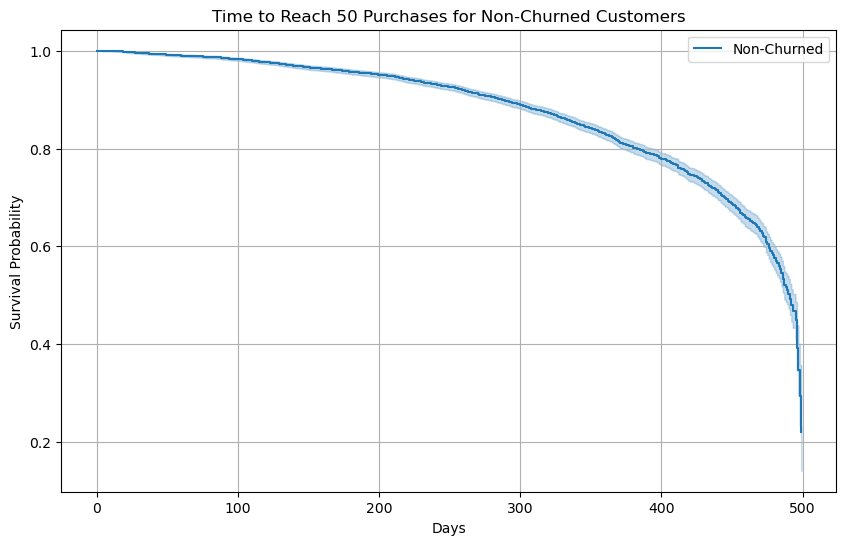

In [106]:
# Step 5: Additional Analysis
# Analyze time to 50 purchases (conditional on not churning)
non_churned = data[~data['churned']]
kmf.fit(
    durations=non_churned['event_time'],
    event_observed=non_churned['event_observed'],
    label='Non-Churned'
)
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Time to Reach 50 Purchases for Non-Churned Customers')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

In [107]:


# Save cleaned dataset
data.to_csv('cleaned_customer_data.csv', index=False)


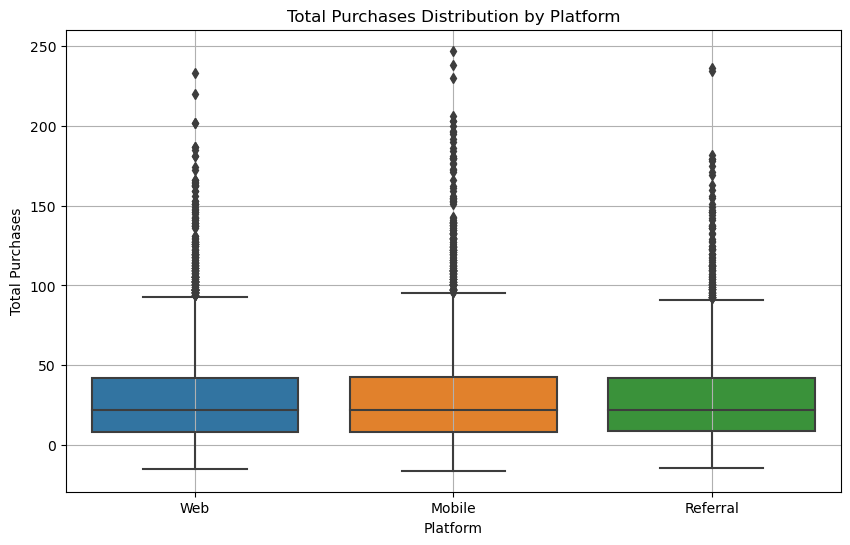

In [116]:
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
sns.boxplot(x='platform', y='total_purchase', data=data)  # Create a box plot with platforms on x-axis and total purchases on y-axis
plt.title('Total Purchases Distribution by Platform')  # Add a title to the plot
plt.ylabel('Total Purchases')  # Label the y-axis
plt.xlabel('Platform')  # Label the x-axis
plt.grid(True)  # Add a grid for easier interpretation of data points
plt.show()  # Display the plot


In [70]:
# Output: Dataframe ready for further exploration
data.head()

,customer_number,customer_register_time,platform,last_login,total_purchase,redeemed_amount,lost,gap_less_than_2_weeks,churned,censored,event_time,event_observed,platform_encoded
0,1,2023-04-13,Web,2024-01-16,10,0,False,False,False,False,278,True,2
1,2,2023-12-15,Mobile,2024-01-15,2,0,False,False,False,False,31,True,0
2,3,2023-09-28,Mobile,2024-08-25,75,10,False,False,False,True,332,False,0
3,4,2023-04-17,Mobile,2023-11-28,18,50,False,False,False,True,225,False,0
4,5,2023-03-13,Mobile,2023-07-17,6,20,True,False,False,True,126,False,0


In [108]:
# Step 6: Simulating Interventions
# Add a hypothetical intervention flag
data['intervention'] = (data['lost']) & (np.random.rand(len(data)) < 0.5)  # 50% chance to receive intervention

# Encode the intervention
data['intervention_encoded'] = data['intervention'].astype(int)

# Re-fit the Cox model with intervention included
cph_intervention = CoxPHFitter()
cph_intervention.fit(data[['event_time', 'event_observed', 'platform_encoded', 'total_purchase', 'redeemed_binary', 'intervention_encoded']], 
                     duration_col='event_time', event_col='event_observed')

# Print the summary of the new model
cph_intervention.print_summary()

<lifelines.CoxPHFitter: fitted with 10000 total observations, 6028 right-censored observations>
             duration col = 'event_time'
                event col = 'event_observed'
      baseline estimation = breslow
   number of observations = 10000
number of events observed = 3972
   partial log-likelihood = -32284.68
         time fit was run = 2025-01-13 04:19:33 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
platform_encoded      -0.03       0.97       0.02            -0.06             0.01                 0.94                 1.01
total_purchase         0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
redeemed_binary       -0.01       0.99       0.03            -0.07             0.05                 0.93                 1.06
intervention_encoded   2.29       9.83       0.04             2.21             2.36                 9.11                10.60

                       cmp to     z      p   -log2(p)
covariate                                            
platform_encoded         0.00 -1.55   0.12       3.04
total_purchase           0.00 35.00 <0.005     889.14
redeemed_binary          0.00 -0.25   0.80       0.32
intervention_encoded     0.00 58.94 <0.005        inf
---
Concordance = 0.74
Partial AIC = 64577.37
log-likelihood ratio test = 3821.39 on 4 df
-log2(p) of ll-ratio test = inf

<Figure size 1000x600 with 0 Axes>

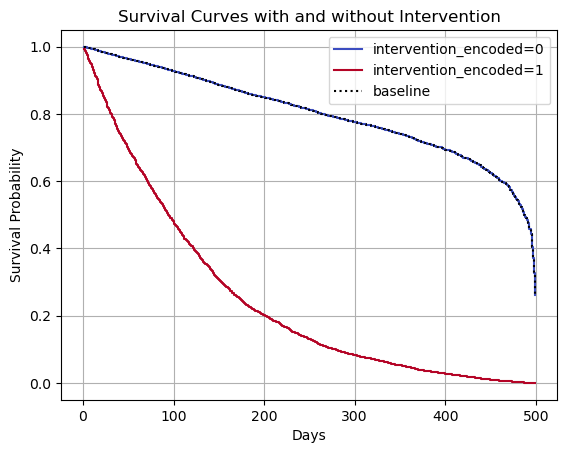

In [124]:
# Visualize the effect of intervention using the updated method
plt.figure(figsize=(10, 6))
cph_intervention.plot_partial_effects_on_outcome(
    covariates='intervention_encoded',
    values=[0, 1],  # 0 = No Intervention, 1 = Intervention
    cmap='coolwarm'
)
plt.title('Survival Curves with and without Intervention')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

In [111]:

# Simulating Reduced Hazard Rate
# Apply a hypothetical 20% reduction in hazard rate for customers with interventions
data['adjusted_hazard'] = np.where(data['intervention'], 0.8 * data['event_observed'], data['event_observed'])

# Re-run the Kaplan-Meier Analysis
kmf_intervention = KaplanMeierFitter()

Text(0, 0.5, 'Survival Probability')

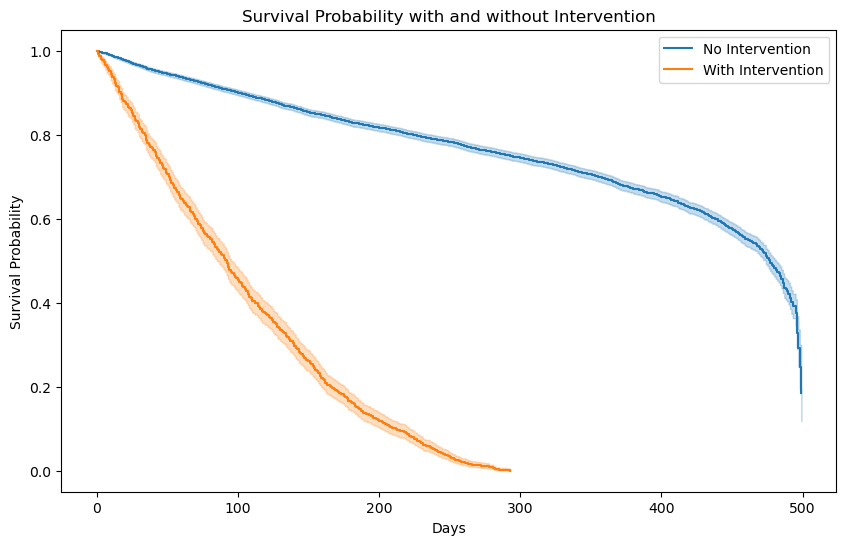

In [114]:
plt.figure(figsize=(10, 6))

# Without intervention
kmf_intervention.fit(durations=data[data['intervention'] == 0]['event_time'], 
                     event_observed=data[data['intervention'] == 0]['event_observed'], label='No Intervention')
kmf_intervention.plot_survival_function(ci_show=True)

# With intervention
kmf_intervention.fit(durations=data[data['intervention'] == 1]['event_time'], 
                     event_observed=data[data['intervention'] == 1]['event_observed'], label='With Intervention')
kmf_intervention.plot_survival_function(ci_show=True)

plt.title('Survival Probability with and without Intervention')
plt.xlabel('Days')
plt.ylabel('Survival Probability')

In [115]:
# Save cleaned dataset
data.to_csv('cleaned_customer_data_with_intervention.csv', index=False)

# Output: Dataframe ready for further exploration
data.head()

,customer_number,customer_register_time,platform,last_login,total_purchase,redeemed_amount,lost,churned,censored,success,event_time,event_observed,platform_encoded,redeemed_binary,intervention,intervention_encoded,adjusted_hazard
0,1,2023-04-13,Web,2024-01-12,34,50,False,False,True,True,274,False,2,1,False,0,0.0
1,2,2023-12-15,Mobile,2024-01-11,55,0,False,False,False,False,27,True,0,0,False,0,1.0
2,3,2023-09-28,Mobile,2024-08-21,1,20,False,False,True,True,328,False,0,1,False,0,0.0
3,4,2023-04-17,Mobile,2024-05-11,0,20,False,False,True,True,390,False,0,1,False,0,0.0
4,5,2023-03-13,Mobile,2024-06-14,7,0,False,False,True,False,459,False,0,0,False,0,0.0
